# Table of Contents
1. [Introduction](#intro)
2. [Installing required packages](#install)
3. [Loading  Datasets and Data Description](#data)
    * 3.1.[Fact Market Demand Data](#fact)
    * 3.2.[Customer Demographics Data](#demograpic)
    * 3.3.[Zip Code Data](#zip)
    * 3.4 [Missing Data](#missing)
4. [Modeling](#modeling)  
    * 4.1.[Prophet Model](#prophet)
        - 4.1.1 [Holiday Data](#holiday)
        - 4.1.2 [Question 1](#q1)
        - 4.1.3 [Question 2](#q2)
        - 4.1.4 [Question 3](#q3)
5. [Conclusion](#Conclusion)


# <a name="intro"></a> 1. Introduction

Swire Coca-Cola  is continually introducing innovative products into the market. Innovation diversifies product offerings, meeting evolving consumer trends. This strategy, marked by unique products and premium pricing, expands market reach and attracts new customers. It responds to technology changes and regulations, ensuring cost efficiency and compliance. Additionally, it rejuvenates sales and marketing. In essence, product innovation is essential for staying relevant, driving revenue, and sustaining long-term growth in a dynamic market.

So, Swire Coca-Cola wants to optimize its production planning and inventory management for these novel beverages. The challenge for Swire is to forecast the demand for these new products accurately to ensure optimal production quantities, prevent out-of-stock and overproduction, minimize costs, and maximize customer satisfaction. The Business problem is to accurately predict the weekly demand of the innovation products. The focus of our project will be on optimal production planning, cost minimization, and market location and date prediction.



The Analytical Problem is to forecast the details expected by the Swire for the 7 innovation products that are planned to be launched in the near future. The basic details of each of the new innovation products are provided so that it can be compared against the historical data and can be used to forecast the sales of the innovation products as close as possible to the real time sales.

The key factors for the Items are the Caloric Segment, Market Category, Manufacturer, Brand, Package Type and Flavor which will be used as the independent variables from the Previous years data to create a Forecast for the new innovation Products. So, the Target variable is the Dollar Sales/unit sales for the innovation products.


In this notebook we will create the forecasting models to predict the demand for the new innovation products that the Swire team is expecting to launch in the next year. The scope includes creating the end-to-end development of the forecasting models to find the pattern of the sales for the products and also to discover some insights for improving the sales of innovation products.  It aims to provide Swire with the insights and tools necessary to maintain its Sales while making data-driven decisions that can contribute to the success of the innovation Products.

# <a name="install"></a>2. Installing required packages

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install google.cloud.bigquery

In [ ]:
import os
import numpy as np
import pandas as pd
import math
import itertools
from scipy import stats
import time


#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mp
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#xgboost
from xgboost import XGBRegressor

#sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


In [ ]:

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})


In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd

from google.colab import auth

# Authenticate user
auth.authenticate_user()

In [ ]:
# Create a BigQuery client
client = bigquery.Client(project='is-6813-spring-24')

# <a name="data"></a> 3. Loading  Datasets and Data Description

## <a name = "fact"> </a> 3.1 Fact Market Demand Data

The main data file is the fact_market_demand data since that seems to hold the most value for answering the business problem. There are 10 fields and 24,461,424 rows. The columns are data, unit_sales, caloric_segment, category, manufacturer, brand, package, item, market_key and dollar_sales.

The date range is nearly three full years, spanning December 2020 to October 2023. The caloric segment is a categorical column with values Regular and Diet/light.


In [ ]:
# Get Fact_Market_Demand Data from BigQuery

fact_demand_query = """
select * from `swire.fact_market_demand`
"""
# Execute the query
fact_demand_query_job = client.query(fact_demand_query)

# Get the results as a Pandas DataFrame
Fact_Demand_data = fact_demand_query_job.to_dataframe()

# Display Fact_market_demand data
Fact_Demand_data.head()

,DATE,MARKET_KEY,CALORIC_SEGMENT,CATEGORY,UNIT_SALES,DOLLAR_SALES,MANUFACTURER,BRAND,PACKAGE,ITEM
0,2022-04-02,464,DIET/LIGHT,SSD,35.00,194.35,COCOS,DIET BUBBLE JOY ADVANTAGEOUS CF,12SMALL 8ONE SHADYES JUG,DIET BUBBLE JOY ADVANTAGEOUS CAFFEINE FREE GEN...
1,2023-04-22,951,DIET/LIGHT,SSD,67.00,124.61,COCOS,DIET BUBBLE JOY ADVANTAGEOUS CF,2L MULTI JUG,DIET BUBBLE JOY ADVANTAGEOUS CAFFEINE FREE GEN...
2,2021-01-09,882,REGULAR,SSD,14.00,25.37,COCOS,CINNAMON BUBBLE JOY ADVANTAGEOUS,20SMALL MULTI JUG,KOOL! GENTLE DRINK CINNAMON COLA JUG 20 LIQUID...
3,2022-10-22,951,DIET/LIGHT,SSD,6.00,9.00,SWIRE-CC,DIET SPARKLING JACCEPTABLETLESTER,1L MULTI JUG,DIET SPARKLING JACCEPTABLETLESTER TONIC WATER ...
4,2021-10-30,613,DIET/LIGHT,SSD,94.00,490.49,JOLLYS,HILL MOISTURE ZERO SUGAR MAJOR MELON,12SMALL 12ONE CUP,RAINING ZERO SUGAR GENTLE DRINK MAJOR CANES A...


In [ ]:
# Get a summary of the dataset
print(Fact_Demand_data.describe())

       MARKET_KEY  UNIT_SALES  DOLLAR_SALES
count 24461424.00 24461424.00   24461424.00
mean       593.14      174.37        591.14
std        605.88      857.81       3040.54
min          1.00        0.04          0.01
25%        260.00       11.00         36.59
50%        547.00       40.00        135.05
75%        845.00      126.00        427.14
max       6802.00    96776.00     492591.07


In [ ]:
print(Fact_Demand_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24461424 entries, 0 to 24461423
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   DATE             dbdate 
 1   MARKET_KEY       Int64  
 2   CALORIC_SEGMENT  object 
 3   CATEGORY         object 
 4   UNIT_SALES       float64
 5   DOLLAR_SALES     float64
 6   MANUFACTURER     object 
 7   BRAND            object 
 8   PACKAGE          object 
 9   ITEM             object 
dtypes: Int64(1), dbdate(1), float64(2), object(6)
memory usage: 1.8+ GB
None


In [ ]:
# Check for missing values
print(Fact_Demand_data.isnull().sum())

DATE                   0
MARKET_KEY             0
CALORIC_SEGMENT    59725
CATEGORY               0
UNIT_SALES             0
DOLLAR_SALES           0
MANUFACTURER           0
BRAND                  0
PACKAGE                0
ITEM                   0
dtype: int64




In the Fact Demand data we can see that there are 59725 missing data in the CALORIC_SEGMENT Column. Before replacing that let us look at how the CALORIC_SEGMENT data is disctributed by using the count SQL query from Big Query as the processing time will be more if done from dataframe object.



In [ ]:
# Get Caloric Segment data from Fact_Market_Demand Data from BigQuery

CS_query = """
select CALORIC_SEGMENT,
count(*) as Count_caloric_segment
from `swire.fact_market_demand`
group by CALORIC_SEGMENT;
"""
# Execute the query
CS_job = client.query(CS_query)

# Get the results as a Pandas DataFrame
CS_data = CS_job.to_dataframe()

CS_data.head()

,CALORIC_SEGMENT,Count_caloric_segment
0,REGULAR,12231585
1,DIET/LIGHT,12170114
2,None,59725


## <a name = "demographic"> </a> 3.2 Customer Demographics Data

The customer_demographics data provides information on the demographics with respect to zip codes like Age, Gender with age, Education, Income range, Marraige status, Race and Household information.

All of these demographic information is combined and can be divided by filtering the 'Segment' field for each type like Household income, education, etc.

In [ ]:
# Get consumer_demographics Data from BigQuery

demograph_query = """
select * from `swire.consumer_demographics`
"""
# Execute the query
demograph_query_job = client.query(demograph_query)

# Get the results as a Pandas DataFrame
Demographics_data = demograph_query_job.to_dataframe()

# Display Fact_market_demand data
Demographics_data.head()

,Geography_Name,Zip,City,State,Segment,Criteria,Count,Criteria_Unit
0,"57064 Tea, SD",57064,Tea,SD,Household Income,"Income Under $10,000",36,HHs
1,"57064 Tea, SD",57064,Tea,SD,Household Income,"Income $10,000 - $19,999",86,HHs
2,"57064 Tea, SD",57064,Tea,SD,Household Income,"Income $20,000 - $29,999",87,HHs
3,"57064 Tea, SD",57064,Tea,SD,Household Income,"Income $30,000 - $39,999",137,HHs
4,"57064 Tea, SD",57064,Tea,SD,Household Income,"Income $40,000 - $49,999",85,HHs


In [ ]:
# Check for missing value in Demographics data
print(Demographics_data.isnull().sum())

Geography_Name    0
Zip               0
City              0
State             0
Segment           0
Criteria          0
Count             0
Criteria_Unit     0
dtype: int64


## <a name = "zip"> </a> 3.3 Zip Code Data

This zip to market unit mapping data contains only Zip code to the market key information. This information can be used to connect the Demographics data to the Fact_Market_Demand data and also to know which Market key belongs to which region in country based on the Zip codes.

In [ ]:
# Get zip_to_market_unit_mapping Data from BigQuery

zip_market_query = """
select * from `swire.zip_to_market_unit_mapping`
"""
# Execute the query
zip_market_query_job = client.query(zip_market_query)

# Get the results as a Pandas DataFrame
zip_market_data = zip_market_query_job.to_dataframe()

# Display Fact_market_demand data
zip_market_data.head()

,ZIP_CODE,MARKET_KEY
0,83462,1
1,83463,1
2,83466,1
3,83467,1
4,83525,1


In [ ]:
# Check for missing values in Zip Market data
print(zip_market_data.isnull().sum())

ZIP_CODE      0
MARKET_KEY    0
dtype: int64


## 3.5.<a name="features"></a> Feature Engineering

Before starting the Data Exploration, we want to include few of the new columns derived from the original data and added into the data.

Let us join the Demographics data with the Zip_to_market Data to get the States for each of the Market keys. Since some Market_keys contain zipcodes of multiple states we divide states by '/' and keep it in one column named 'States'.

Then we will attach the States column to the main fact_demand_data so that we get the states information for each of sales data.

We will get all this from Bigquery to reduce the run time.

In [ ]:
#Google Big Query
ZMS_query = """
SELECT DISTINCT c.*, d.States
FROM `is-6813-spring-24.swire.fact_market_demand` as c
inner join
( SELECT a.MARKET_KEY, STRING_AGG(DISTINCT b.State, '/') AS States
FROM `is-6813-spring-24.swire.zip_to_market_unit_mapping` AS a
INNER JOIN `is-6813-spring-24.swire.consumer_demographics` AS b
ON b.Zip = a.ZIP_CODE
GROUP BY a.MARKET_KEY )
as d
ON c.MARKET_KEY = d.MARKET_KEY
ORDER BY c.DATE, c. MARKET_KEY, c.ITEM
"""
# Execute the query
ZMS_job = client.query(ZMS_query)

# Get the results as a Pandas DataFrame
fact_demand_state_data = ZMS_job.to_dataframe()

fact_demand_state_data.head()

,DATE,MARKET_KEY,CALORIC_SEGMENT,CATEGORY,UNIT_SALES,DOLLAR_SALES,MANUFACTURER,BRAND,PACKAGE,ITEM,States
0,2020-12-05,1,REGULAR,ENERGY,3.00,23.88,JORDYS,LIQUORICE,ALL OTHER ONES,AAE LIQUORICE XTREME DIETARY HEALTH SUPPLEMENT...,ID
1,2020-12-05,1,REGULAR,ENERGY,1.00,7.96,JORDYS,LIQUORICE,ALL OTHER ONES,AAE LIQUORICE XTREME REVITALIZING BOOST LIQUID...,ID
2,2020-12-05,1,DIET/LIGHT,ENERGY,9.00,23.78,JORDYS,LIQUORICE,ALL OTHER ONES,AAE LIQUORICE XTREME REVITALIZING BOOST LIQUID...,ID
3,2020-12-05,1,DIET/LIGHT,SPARKLING WATER,114.00,375.09,JOLLYS,BUBBLE JOY,12SMALL 8ONE CUP,BUBBLE JOY SPARKLING WATER CASAVA BUBBLE JOY ...,ID
4,2020-12-05,1,DIET/LIGHT,SPARKLING WATER,178.00,588.82,JOLLYS,BUBBLE JOY,12SMALL 8ONE CUP,BUBBLE JOY SPARKLING WATER DURIAN BUBBLE JOY ...,ID


In [ ]:
# Convert DATE column to datetime
fact_demand_state_data['DATE'] = pd.to_datetime(fact_demand_state_data['DATE'])


In [ ]:
fact_demand_state_data.head()

,DATE,MARKET_KEY,CALORIC_SEGMENT,CATEGORY,UNIT_SALES,DOLLAR_SALES,MANUFACTURER,BRAND,PACKAGE,ITEM,States
0,2020-12-05,1,REGULAR,ENERGY,3.00,23.88,JORDYS,LIQUORICE,ALL OTHER ONES,AAE LIQUORICE XTREME DIETARY HEALTH SUPPLEMENT...,ID
1,2020-12-05,1,REGULAR,ENERGY,1.00,7.96,JORDYS,LIQUORICE,ALL OTHER ONES,AAE LIQUORICE XTREME REVITALIZING BOOST LIQUID...,ID
2,2020-12-05,1,DIET/LIGHT,ENERGY,9.00,23.78,JORDYS,LIQUORICE,ALL OTHER ONES,AAE LIQUORICE XTREME REVITALIZING BOOST LIQUID...,ID
3,2020-12-05,1,DIET/LIGHT,SPARKLING WATER,114.00,375.09,JOLLYS,BUBBLE JOY,12SMALL 8ONE CUP,BUBBLE JOY SPARKLING WATER CASAVA BUBBLE JOY ...,ID
4,2020-12-05,1,DIET/LIGHT,SPARKLING WATER,178.00,588.82,JOLLYS,BUBBLE JOY,12SMALL 8ONE CUP,BUBBLE JOY SPARKLING WATER DURIAN BUBBLE JOY ...,ID


##<a name="missing"></a> 3.4. Missing Data

Since both the Regular and Diet/light categories are equal we are unable to categorize the null value to any of the categories without disturbing the other data present. So, We can just replace that Null values with the string of 'Unknown', so that the data is not impacted.

In [ ]:
# Handling missing values

fact_demand_state_data['CALORIC_SEGMENT'].fillna('Unknown', inplace=True)

In [ ]:
# checking for missing data again

print(fact_demand_state_data.isnull().sum())

DATE               0
MARKET_KEY         0
CALORIC_SEGMENT    0
CATEGORY           0
UNIT_SALES         0
DOLLAR_SALES       0
MANUFACTURER       0
BRAND              0
PACKAGE            0
ITEM               0
States             0
dtype: int64


In [ ]:
# Handling missing values

Fact_Demand_data['CALORIC_SEGMENT'].fillna('Unknown', inplace=True)

In [ ]:
# checking for missing data again

print(Fact_Demand_data.isnull().sum())

DATE               0
MARKET_KEY         0
CALORIC_SEGMENT    0
CATEGORY           0
UNIT_SALES         0
DOLLAR_SALES       0
MANUFACTURER       0
BRAND              0
PACKAGE            0
ITEM               0
dtype: int64


# 4. <a name="modeling"></a> Modeling

First defining the required functions like missing_data and MAPE which will help us further in the Modeling Process and for finding the best model for Forecasting.

In [ ]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.

    input: pandas df
    output: pandas df

    '''

    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns:
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred):
    '''
    Mean Absolute Percentage Error (MAPE) Function

    input: list/series for actual values and predicted values
    output: mape value
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


## <a name = "prophet"> </a> 4.1. Prophet Model

## <a name = "holiday"> </a> 4.1.1. Holiday Data

First getting reading the holiday data for the US so that the pattern for the holidays can be understood. The lower window is for -2 so that it can consider 2 dys before the holiday and 1 for upper window, so that it can consider one day after the holiday

In [ ]:
#adding holiday data

holiday = pd.DataFrame([])

for date_, name in sorted(holidays.US(years=[2020,2021,2022,2023,2024]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "US-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

,ds,holiday,lower_window,upper_window
0,2020-01-01,US-Holidays,-2,1
1,2020-01-20,US-Holidays,-2,1
2,2020-02-17,US-Holidays,-2,1
3,2020-05-25,US-Holidays,-2,1
4,2020-07-03,US-Holidays,-2,1


In [ ]:
#converting the column names to lower characters and replacing spaces by underscore
fact_demand_state_data.columns = fact_demand_state_data.columns.str.replace(' ', '_').str.lower()

#converting the date format to year-month-date
fact_demand_state_data['date'] = pd.to_datetime(fact_demand_state_data['date'], format= "%Y/%m/%d")

In [ ]:
# Finding the minimum and maximum dates in the data
min(fact_demand_state_data['date']), max(fact_demand_state_data['date'])

(Timestamp('2020-12-05 00:00:00'), Timestamp('2023-10-28 00:00:00'))

In [ ]:
fact_demand_state_data.head()

,date,market_key,caloric_segment,category,unit_sales,dollar_sales,manufacturer,brand,package,item,states
0,2020-12-05,1,REGULAR,ENERGY,3.00,23.88,JORDYS,LIQUORICE,ALL OTHER ONES,AAE LIQUORICE XTREME DIETARY HEALTH SUPPLEMENT...,ID
1,2020-12-05,1,REGULAR,ENERGY,1.00,7.96,JORDYS,LIQUORICE,ALL OTHER ONES,AAE LIQUORICE XTREME REVITALIZING BOOST LIQUID...,ID
2,2020-12-05,1,DIET/LIGHT,ENERGY,9.00,23.78,JORDYS,LIQUORICE,ALL OTHER ONES,AAE LIQUORICE XTREME REVITALIZING BOOST LIQUID...,ID
3,2020-12-05,1,DIET/LIGHT,SPARKLING WATER,114.00,375.09,JOLLYS,BUBBLE JOY,12SMALL 8ONE CUP,BUBBLE JOY SPARKLING WATER CASAVA BUBBLE JOY ...,ID
4,2020-12-05,1,DIET/LIGHT,SPARKLING WATER,178.00,588.82,JOLLYS,BUBBLE JOY,12SMALL 8ONE CUP,BUBBLE JOY SPARKLING WATER DURIAN BUBBLE JOY ...,ID


## <a name = "q1"> </a> 4.1.2. Question 1

Writing the segments for the Qestion 1.  
a. caloric Segment - Diet  
b. Market Category - SSD   
c. Manufacturer - Swire-CC  
d. Brand - Diet Smash  
e. Package Type - 11Small4One  
f. Flavor - Plum

Now, checking which lines in the data will yield to the most closest for our forecast.





In [ ]:

q1_f1 = fact_demand_state_data['caloric_segment'] == 'DIET/LIGHT'
q1_f2 = fact_demand_state_data['category'] == 'SSD'
q1_f3 = fact_demand_state_data['brand'] == 'DIET SMASH'
q1_f4 = fact_demand_state_data['item'].str.lower().str.contains('plum')

filter_condition_q1 = (( q1_f1 & q1_f2 & q1_f3 ) | ( q1_f4 & q1_f2 & q1_f1 ))

q1_df = fact_demand_state_data[filter_condition_q1]

q1_df.head()

,date,market_key,caloric_segment,category,unit_sales,dollar_sales,manufacturer,brand,package,item,states
2859,2020-12-05,23,DIET/LIGHT,SSD,72.00,115.29,SWIRE-CC,DIET SMASH,2L MULTI JUG,DIET SMASH GENTLE DRINK SUNSET DIET JUG 67.6 ...,OR
6381,2020-12-05,50,DIET/LIGHT,SSD,46.00,74.17,SWIRE-CC,DIET SMASH,2L MULTI JUG,DIET SMASH GENTLE DRINK SUNSET DIET JUG 67.6 ...,WA/ID
7172,2020-12-05,56,DIET/LIGHT,SSD,3.00,13.98,SWIRE-CC,DIET SMASH,12SMALL 12ONE CUP,DIET SMASH GENTLE DRINK SUNSET DIET CUP 12 LI...,OR/WA
7173,2020-12-05,56,DIET/LIGHT,SSD,25.00,33.45,SWIRE-CC,DIET SMASH,2L MULTI JUG,DIET SMASH GENTLE DRINK SUNSET DIET JUG 67.6 ...,OR/WA
9500,2020-12-05,61,DIET/LIGHT,SSD,33.00,53.11,SWIRE-CC,DIET SMASH,2L MULTI JUG,DIET SMASH GENTLE DRINK SUNSET DIET JUG 67.6 ...,OR


In [ ]:
q1_df.shape

(17484, 11)

In [ ]:
min(q1_df['date']), max(q1_df['date'])

(Timestamp('2020-12-05 00:00:00'), Timestamp('2023-10-28 00:00:00'))

In [ ]:
q1_agg_df = q1_df.groupby(['date']).agg({'unit_sales': 'sum', 'item': 'nunique'}).reset_index().sort_values(['date'])
q1_agg_df['unit_sales'] = q1_agg_df['unit_sales'] / q1_agg_df['item']
q1_agg_df.drop(columns=['item'],inplace=True)


In [ ]:
#q1_agg_df = q1_df.groupby(['date']).agg({'unit_sales':'sum'}).reset_index().sort_values(['date'])

In [ ]:
q1_agg_df.head()

,date,unit_sales
0,2020-12-05,3489.50
1,2020-12-12,2793.00
2,2020-12-19,2082.00
3,2020-12-26,1994.00
4,2021-01-02,1515.00


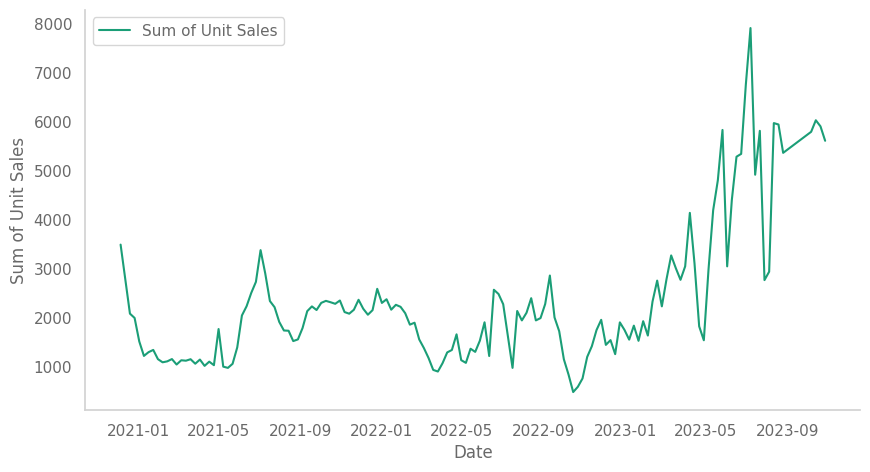

In [ ]:
# @title date vs sum of unit_sales

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
    # Aggregate sum of unit sales by date
  summed = series.groupby('date')['unit_sales'].sum().reset_index()

  xs = summed['date']
  ys = summed['unit_sales']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

# Example usage:
fig, ax = plt.subplots(figsize=(10, 5.2))
df_sorted = q1_agg_df.sort_values('date', ascending=True)
_plot_series(df_sorted, 'Sum of Unit Sales')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
plt.ylabel('Sum of Unit Sales')
plt.legend()
plt.show()

In [ ]:
missing_data(q1_agg_df).head()

,Total,Percent,Types
date,0,0.00,datetime64[ns]
unit_sales,0,0.00,float64


In [ ]:
#total_sales_df1 = q1_agg_df.dropna()

In [ ]:
q1_agg_df.shape

(147, 2)

In [ ]:
Q1_sales_data_df = q1_agg_df[q1_agg_df.date<='2023-06-05']
Q1_test_set_df = q1_agg_df[q1_agg_df.date>='2023-06-05']

In [ ]:
Q1_sales_data_df.shape

(131, 2)

In [ ]:
Q1_test_set_df.shape

(16, 2)

In [ ]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)

[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [ ]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()


In [ ]:
start_time = time.time()

#category_df = Q1_sales_data_df[['date','unit_sales']]

def best_params(category_df):
    category_df.rename(columns={'date': 'ds', 'unit_sales': 'y'}, inplace=True)
    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])

    param_grid = {
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range }

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = []

    # Use cross validation to evaluate all parameters
    for params in all_params:
         m = Prophet(**params).fit(category_df)  # Fit model with given params
         df_cv = cross_validation(m, initial="365 days", period="30 days", horizon = "30 days") #took parallel out
         df_p = performance_metrics(df_cv, rolling_window=1)
         mapes.append(df_p["mape"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["mape"] = mapes

    params_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0])

    return params_dict

params1_dict = best_params(Q1_sales_data_df)

print("--- %s seconds ---" % (time.time() - start_time))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/em65un9_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/jea939j9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43413', 'data', 'file=/tmp/tmpds087y2r/em65un9_.json', 'init=/tmp/tmpds087y2r/jea939j9.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelz87zzrhs/prophet_model-20240331182506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:25:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:25:06 - cmdstanpy - ERROR - Chain [1]

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/b3m1d2sv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/7inbutom.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23734', 'data', 'file=/tmp/tmpds087y2r/b3m1d2sv.json', 'init=/tmp/tmpds087y2r/7inbutom.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelp9boxgpv/prophet_model-20240331182506.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:25:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/8_pprej7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/kxd5cw_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/zdpl0kl2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/tvxsm2n7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20934', 'data', 'file=/tmp/tmpds087y2r/zdpl0kl2.json', 'init=/tmp/tmpds087y2r/tvxsm2n7.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelk2xvryby/prophet_model-20240331182514.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:25:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/wx7obe2c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/vl3_ciea.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/4t0km3jm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/7bktzmmh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11978', 'data', 'file=/tmp/tmpds087y2r/4t0km3jm.json', 'init=/tmp/tmpds087y2r/7bktzmmh.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model3aeq803x/prophet_model-20240331182524.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:25:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/62fxw_wx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/e10czt5g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/1bwcxyzt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/pegp03bz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64018', 'data', 'file=/tmp/tmpds087y2r/1bwcxyzt.json', 'init=/tmp/tmpds087y2r/pegp03bz.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelszw0xczl/prophet_model-20240331182532.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:25:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/1j2if1xl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/wklb22pi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/7shh5f5s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/16wb_fk2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55767', 'data', 'file=/tmp/tmpds087y2r/7shh5f5s.json', 'init=/tmp/tmpds087y2r/16wb_fk2.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model_d75cfip/prophet_model-20240331182541.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:25:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/42mppx7a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/k1m2ggw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/yqrsfkzp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/ct243bx0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37249', 'data', 'file=/tmp/tmpds087y2r/yqrsfkzp.json', 'init=/tmp/tmpds087y2r/ct243bx0.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelusm2zd9o/prophet_model-20240331182549.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:25:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/oc9gpvcc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/pvata0bk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/_h0wn_1g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/mk_d8fix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58502', 'data', 'file=/tmp/tmpds087y2r/_h0wn_1g.json', 'init=/tmp/tmpds087y2r/mk_d8fix.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model8qsn9iiv/prophet_model-20240331182555.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:25:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:25:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/jjo5s46z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/2n_g168f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/dp6vy2gn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/pxrglvhx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51711', 'data', 'file=/tmp/tmpds087y2r/dp6vy2gn.json', 'init=/tmp/tmpds087y2r/pxrglvhx.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model0jnyailw/prophet_model-20240331182603.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:26:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/3uh9h8n6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/t1lfwsvf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/30i3yeen.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/oqihxq8d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46036', 'data', 'file=/tmp/tmpds087y2r/30i3yeen.json', 'init=/tmp/tmpds087y2r/oqihxq8d.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model2a05l_8_/prophet_model-20240331182610.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:26:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/m7rdzqo5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/7bgbm8hs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/h_xp5fxh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/e9gkv7y1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87052', 'data', 'file=/tmp/tmpds087y2r/h_xp5fxh.json', 'init=/tmp/tmpds087y2r/e9gkv7y1.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modell_4_1h8i/prophet_model-20240331182617.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:26:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/m1ezfht_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/yo_qhi_r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/w5qe_tq4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/i60x152b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63396', 'data', 'file=/tmp/tmpds087y2r/w5qe_tq4.json', 'init=/tmp/tmpds087y2r/i60x152b.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelkqmgf6yl/prophet_model-20240331182624.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:26:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/32ja5j2u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/ybmbkdrl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/q3pd6uwj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/aodtr5nz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53403', 'data', 'file=/tmp/tmpds087y2r/q3pd6uwj.json', 'init=/tmp/tmpds087y2r/aodtr5nz.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelg3roizrr/prophet_model-20240331182632.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:26:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/jdhkg1f7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/5fol5s1q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/gudt6yol.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/nnc320pk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54937', 'data', 'file=/tmp/tmpds087y2r/gudt6yol.json', 'init=/tmp/tmpds087y2r/nnc320pk.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model9h2s8wkk/prophet_model-20240331182642.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:26:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/u_tkemg0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/jgdcmuoj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/p8yzvbtg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/264_t7br.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42146', 'data', 'file=/tmp/tmpds087y2r/p8yzvbtg.json', 'init=/tmp/tmpds087y2r/264_t7br.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model9pnm1ht8/prophet_model-20240331182651.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:26:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/ot66yjvw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/0k7w8llo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/038cfn65.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/ihk629l3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37181', 'data', 'file=/tmp/tmpds087y2r/038cfn65.json', 'init=/tmp/tmpds087y2r/ihk629l3.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelnlm5w3vh/prophet_model-20240331182659.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:26:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:26:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/4bfw02ny.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/j6yroah7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/84atiddt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/s5kj_d16.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68173', 'data', 'file=/tmp/tmpds087y2r/84atiddt.json', 'init=/tmp/tmpds087y2r/s5kj_d16.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelqv0r3jfn/prophet_model-20240331182707.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:27:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/f3q_1u1o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/30eayjn9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/wl_11pdd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/i4llyzge.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94897', 'data', 'file=/tmp/tmpds087y2r/wl_11pdd.json', 'init=/tmp/tmpds087y2r/i4llyzge.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelc79hw920/prophet_model-20240331182716.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:27:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/3fpfjoor.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/vofzcd4k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/kzn3ygtl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/0ly1y_0b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17613', 'data', 'file=/tmp/tmpds087y2r/kzn3ygtl.json', 'init=/tmp/tmpds087y2r/0ly1y_0b.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model2czusfaz/prophet_model-20240331182724.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:27:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/sqga3uke.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/5d3kq3ug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/yaci7u66.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/vkya9m31.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46620', 'data', 'file=/tmp/tmpds087y2r/yaci7u66.json', 'init=/tmp/tmpds087y2r/vkya9m31.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model_3ynn395/prophet_model-20240331182733.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:27:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/3pg8n2ja.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/3gqr5yy_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/uv447tw6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/sw14an46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87838', 'data', 'file=/tmp/tmpds087y2r/uv447tw6.json', 'init=/tmp/tmpds087y2r/sw14an46.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelyu3037kn/prophet_model-20240331182741.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:27:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/2xqhwyc5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/nlyym577.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/1zallx_b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/l0cn5dqn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90803', 'data', 'file=/tmp/tmpds087y2r/1zallx_b.json', 'init=/tmp/tmpds087y2r/l0cn5dqn.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelwgjnt188/prophet_model-20240331182750.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:27:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/oq0mngjx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/rnf47qog.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/mj90zof4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/wb23nep7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79355', 'data', 'file=/tmp/tmpds087y2r/mj90zof4.json', 'init=/tmp/tmpds087y2r/wb23nep7.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelmd0inuhm/prophet_model-20240331182759.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:27:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:27:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/daom1wcj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/jownhmdn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/inofud6g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/skg9ks9v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85866', 'data', 'file=/tmp/tmpds087y2r/inofud6g.json', 'init=/tmp/tmpds087y2r/skg9ks9v.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model5dh0h6a8/prophet_model-20240331182807.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:28:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/6_houhg_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/0lr2zyng.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/2ewpnwy5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/p_ck1irp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46338', 'data', 'file=/tmp/tmpds087y2r/2ewpnwy5.json', 'init=/tmp/tmpds087y2r/p_ck1irp.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelx_383hfx/prophet_model-20240331182815.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:28:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/aq72a7a1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/z_dxksl4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/ldsgue2f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/x66p0ylp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87381', 'data', 'file=/tmp/tmpds087y2r/ldsgue2f.json', 'init=/tmp/tmpds087y2r/x66p0ylp.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelxi0udd2i/prophet_model-20240331182825.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:28:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/k229hsrb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/sqyj3iyy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

--- 209.39410281181335 seconds ---


In [ ]:
params1_dict


{'changepoint_prior_scale': 0.12575,
 'seasonality_prior_scale': 0.01,
 'mape': 0.406511161078941}

In [ ]:
prediction_days = 16
forecast_start_date = max(Q1_sales_data_df.ds) - timedelta(prediction_days)

In [ ]:
#PROPHET MODEL

#model
m = Prophet(changepoint_prior_scale=params1_dict['changepoint_prior_scale'],
            seasonality_prior_scale=params1_dict['seasonality_prior_scale'],
            holidays=holiday)

m.fit(Q1_sales_data_df)

future = m.make_future_dataframe(periods=52, freq='W-SAT')
fcst_prophet_train = m.predict(future)

filter = fcst_prophet_train['ds']>=forecast_start_date
predicted_df = fcst_prophet_train[filter][['ds','yhat']]
predicted_df = predicted_df.merge(Q1_sales_data_df)

print(mape(predicted_df['y'],predicted_df['yhat']))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/kqxry86t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/91x27de1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17152', 'data', 'file=/tmp/tmpds087y2r/kqxry86t.json', 'init=/tmp/tmpds087y2r/91x27de1.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelwv2zipjj/prophet_model-20240331182835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:28:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:28:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


26.353485952312354


In [ ]:
print(forecast_start_date)

2023-05-18 00:00:00


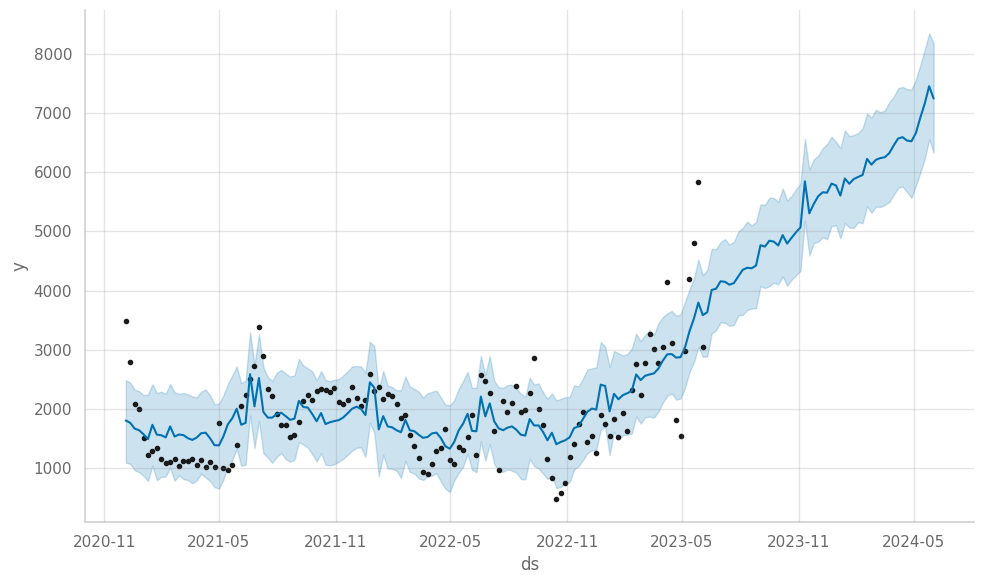

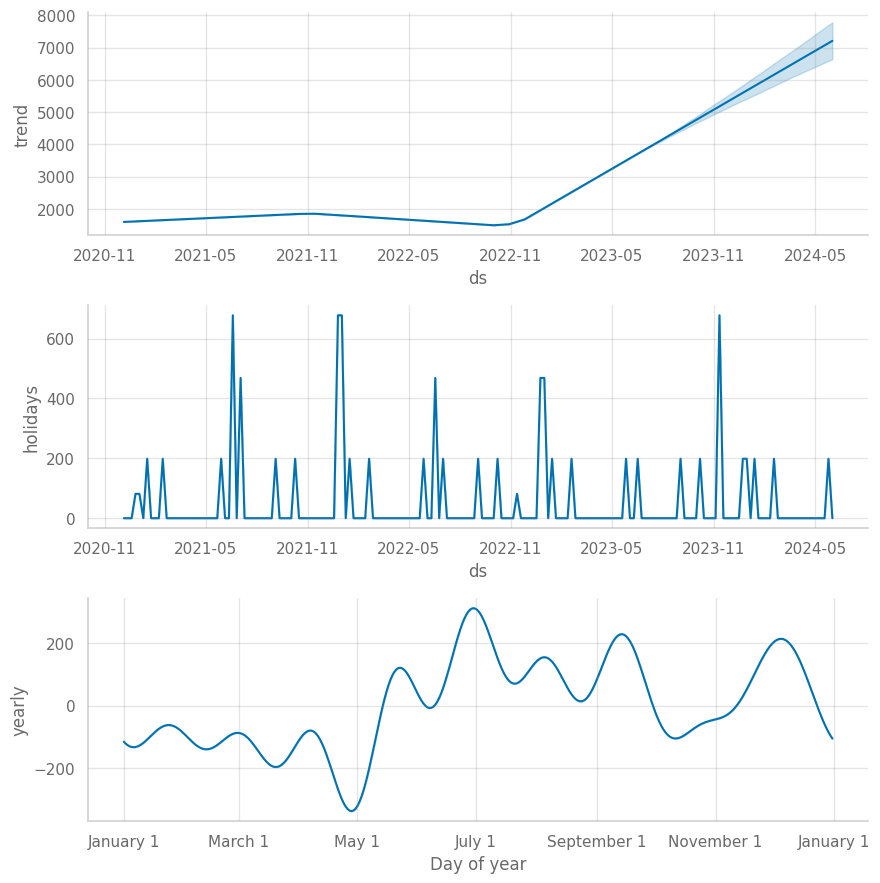

In [ ]:
fig1 = m.plot(fcst_prophet_train)
fig2 = m.plot_components(fcst_prophet_train)

forecasted_df = fcst_prophet_train[fcst_prophet_train['ds']>=forecast_start_date]


In [ ]:
forecast_start_date = '2023-06-05'

future = m.make_future_dataframe(periods=16, freq='W-SAT')
fcst_prophet_train = m.predict(future)

filter = fcst_prophet_train['ds']>=forecast_start_date
predicted_df = fcst_prophet_train[filter][['ds','yhat']]



# Calculate Mean Absolute Percentage Error (MAPE)
mape_v = mape(Q1_test_set_df['unit_sales'],predicted_df['yhat'])


# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(Q1_test_set_df['unit_sales'],predicted_df['yhat'])

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Q1_test_set_df['unit_sales'],predicted_df['yhat'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R2)
r2 = r2_score(Q1_test_set_df['unit_sales'],predicted_df['yhat'])

print(f"-----------------------Features---------------------------")

print(f'Mean Absolute Error- MAE: {mae}')
print(f'Mean Squared Error- MSE: {mse}')
print(f'Root Mean Square Error- RMSE: {rmse}')
print(f'R2:R-squared{r2}')
print(f'Mean Absolute Percentage Error- MAPE: {mape_v}')

-----------------------Features---------------------------
Mean Absolute Error- MAE: 1457.7534713440446
Mean Squared Error- MSE: 2669798.2981711663
Root Mean Square Error- RMSE: 1633.9517429138373
R2:R-squared-0.7819012076829785
Mean Absolute Percentage Error- MAPE: 27.5135405614711


In [ ]:
forecast_start_date = '2023-12-30'

future = m.make_future_dataframe(periods=85, freq='W-SAT')
fcst_prophet_train = m.predict(future)

filter = fcst_prophet_train['ds']>=forecast_start_date
predicted_13_df = fcst_prophet_train[filter][['ds','yhat']]

predicted_13_df.tail()

,ds,yhat
211,2024-12-21,9268.88
212,2024-12-28,9231.06
213,2025-01-04,9246.59
214,2025-01-11,9327.43
215,2025-01-18,9437.88


In [ ]:
# Initialize variables to store the maximum sum and its corresponding index
max_sum = float('-inf')
max_index = -1

# Calculate the sum of the first 13 values as the initial maximum sum
current_sum = predicted_13_df['yhat'].iloc[:13].sum()

# Iterate through the DataFrame to find the maximum sum
for i in range(len(predicted_13_df) - 13):
    if current_sum > max_sum:
        max_sum = current_sum
        max_index = i

    # Update the sum for the next window
    current_sum = current_sum - predicted_13_df['yhat'].iloc[i] + predicted_13_df['yhat'].iloc[i + 13]

# Print the maximum sum and its corresponding index
print("Maximum sum:", max_sum)
print("Index of the first element in the set:", max_index)

print("Date of the start of the 13th year:", predicted_13_df['ds'].iloc[max_index])

print(predicted_13_df.iloc[max_index:max_index+13])


Maximum sum: 117786.38842817597
Index of the first element in the set: 42
Date of the start of the 13th year: 2024-10-19 00:00:00
            ds    yhat
202 2024-10-19 8526.12
203 2024-10-26 8622.29
204 2024-11-02 8704.72
205 2024-11-09 8997.61
206 2024-11-16 8930.24
207 2024-11-23 9087.35
208 2024-11-30 9226.93
209 2024-12-07 9305.92
210 2024-12-14 9311.25
211 2024-12-21 9268.88
212 2024-12-28 9231.06
213 2025-01-04 9246.59
214 2025-01-11 9327.43


From the above Forecast and the calculations the 13 weeks that would perform the best in the market is the week from 19th October,2024 to 18th January, 2025. The total forecast in demand in unit sales for those weeks is estimated to be 117786.38

## <a name = "q2"> </a> 4.1.3. Question 2

Writing the segments for the Qestion 2.  
a. caloric Segment - Regular  
b. Market Category - SSD   
c. Manufacturer - Swire-CC  
d. Brand - Sparkling Jacceptabletlester  
e. Package Type - 11Small MLT  
f. Flavor - Avocado

In [ ]:
q2_f1 = fact_demand_state_data['caloric_segment'] == 'REGULAR'
q2_f2 = fact_demand_state_data['category'] == 'SSD'
q2_f3 = fact_demand_state_data['manufacturer'].str.lower().str.contains('swire')
q2_f4 = fact_demand_state_data['item'].str.lower().str.contains('avocado')

filter_condition_q2 = ( q2_f1 & q2_f2 & q2_f3 & q2_f4 )

q2_df = fact_demand_state_data[filter_condition_q2]

q2_df.head()

,date,market_key,caloric_segment,category,unit_sales,dollar_sales,manufacturer,brand,package,item,states
296,2020-12-05,1,REGULAR,SSD,241.00,1258.99,SWIRE-CC,JUICY SQUIRREL,12SMALL 12ONE CUP,JUICY SQUIRREL GENTLE DRINK AVOCADO CUP 12 LI...,ID
301,2020-12-05,1,REGULAR,SSD,127.00,649.44,SWIRE-CC,JUICY SQUIRREL,12SMALL 12ONE CUP,JUICY SQUIRREL GENTLE DRINK RUBY RED AVOCADO ...,ID
302,2020-12-05,1,REGULAR,SSD,107.00,199.96,SWIRE-CC,JUICY SQUIRREL,20SMALL MULTI JUG,JUICY SQUIRREL GENTLE DRINK RUBY RED AVOCADO ...,ID
995,2020-12-05,6,REGULAR,SSD,8.00,23.04,SWIRE-CC,JUICY SQUIRREL,.5L 6ONE JUG,JUICY SQUIRREL GENTLE DRINK AVOCADO BURST JUG...,ID
996,2020-12-05,6,REGULAR,SSD,415.00,2144.96,SWIRE-CC,JUICY SQUIRREL,12SMALL 12ONE CUP,JUICY SQUIRREL GENTLE DRINK AVOCADO CUP 12 LI...,ID


In [ ]:
q2_df.shape

(181912, 11)

In [ ]:
min(q2_df['date']), max(q2_df['date'])

(Timestamp('2020-12-05 00:00:00'), Timestamp('2023-10-28 00:00:00'))

In [ ]:
#q2_agg_df = q2_df.groupby(['date']).agg({'unit_sales':'sum'}).reset_index().sort_values(['date'])

q2_agg_df = q2_df.groupby(['date']).agg({'unit_sales': 'sum', 'item': 'nunique'}).reset_index().sort_values(['date'])
q2_agg_df['unit_sales'] = q2_agg_df['unit_sales'] / q2_agg_df['item']
q2_agg_df.drop(columns=['item'],inplace=True)


In [ ]:
q2_agg_df.head()

,date,unit_sales
0,2020-12-05,5539.45
1,2020-12-12,6760.44
2,2020-12-19,6747.75
3,2020-12-26,8836.45
4,2021-01-02,7164.84


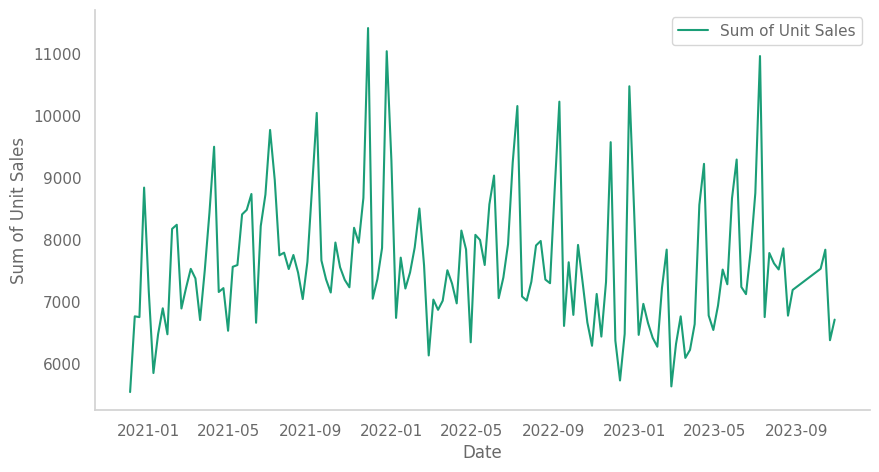

In [ ]:
# @title date vs sum of unit_sales for Q2

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
    # Aggregate sum of unit sales by date
  summed = series.groupby('date')['unit_sales'].sum().reset_index()

  xs = summed['date']
  ys = summed['unit_sales']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

# Example usage:
fig, ax = plt.subplots(figsize=(10, 5.2))
df_sorted = q2_agg_df.sort_values('date', ascending=True)
_plot_series(df_sorted, 'Sum of Unit Sales')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
plt.ylabel('Sum of Unit Sales')
plt.legend()
plt.show()

In [ ]:
Q2_sales_data_df = q2_agg_df[q2_agg_df.date<='2023-06-05']
Q2_test_set_df = q2_agg_df[q2_agg_df.date>='2023-06-05']

In [ ]:
Q2_sales_data_df.head()

,date,unit_sales
0,2020-12-05,5539.45
1,2020-12-12,6760.44
2,2020-12-19,6747.75
3,2020-12-26,8836.45
4,2021-01-02,7164.84


In [ ]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
seasonality_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()

In [ ]:
# getting the best parametes for Question 2
params_dict2 = best_params(Q2_sales_data_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/ykxk7sjo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/13kzye50.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19103', 'data', 'file=/tmp/tmpds087y2r/ykxk7sjo.json', 'init=/tmp/tmpds087y2r/13kzye50.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelq4o4ylkk/prophet_model-20240331182916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:29:16 - cmdstanpy - ERROR - Chain [1]

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/dzkx8wl7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/kehvol0v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14250', 'data', 'file=/tmp/tmpds087y2r/dzkx8wl7.json', 'init=/tmp/tmpds087y2r/kehvol0v.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model8bh7u3by/prophet_model-20240331182917.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:29:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/f3nfmo5g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/4f9e799_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/k1eojj42.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/lsnv61mn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2623', 'data', 'file=/tmp/tmpds087y2r/k1eojj42.json', 'init=/tmp/tmpds087y2r/lsnv61mn.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model4grjul6h/prophet_model-20240331182923.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:29:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/xnvdaa34.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/06ml6onr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/dstij7ow.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/88ar6_q4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61027', 'data', 'file=/tmp/tmpds087y2r/dstij7ow.json', 'init=/tmp/tmpds087y2r/88ar6_q4.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model0q42hxlk/prophet_model-20240331182930.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:29:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/4v7vzcwb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/1fxd95ga.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/qpx9_u1u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/uidfc71k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49078', 'data', 'file=/tmp/tmpds087y2r/qpx9_u1u.json', 'init=/tmp/tmpds087y2r/uidfc71k.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelckjt8zuu/prophet_model-20240331182943.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:29:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/tl7h1m2x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/hg13fkp2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/7bm0rs7q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/_tci1wp8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4509', 'data', 'file=/tmp/tmpds087y2r/7bm0rs7q.json', 'init=/tmp/tmpds087y2r/_tci1wp8.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelqhia1tpl/prophet_model-20240331182949.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:29:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/xlt9vd54.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/8phl4mui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/u4f_7n0x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/c98r7h6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28744', 'data', 'file=/tmp/tmpds087y2r/u4f_7n0x.json', 'init=/tmp/tmpds087y2r/c98r7h6a.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelipgjdehc/prophet_model-20240331182955.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:29:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/g7wqnizf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/npswj6tc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/jlzgk4rq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/cieo_e3h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34323', 'data', 'file=/tmp/tmpds087y2r/jlzgk4rq.json', 'init=/tmp/tmpds087y2r/cieo_e3h.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelu43s51v3/prophet_model-20240331183001.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:30:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/w12ixkl9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/tklrzu84.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/pbnwicy3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/6z2ritdr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66025', 'data', 'file=/tmp/tmpds087y2r/pbnwicy3.json', 'init=/tmp/tmpds087y2r/6z2ritdr.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelw_4gn77h/prophet_model-20240331183007.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:30:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/txuihcl4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/dhyl7xm6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/8_qic57f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/gqcgzg2j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91057', 'data', 'file=/tmp/tmpds087y2r/8_qic57f.json', 'init=/tmp/tmpds087y2r/gqcgzg2j.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modeluey5z41g/prophet_model-20240331183012.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:30:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/_wc1exx6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/vdi6jku7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/ql7z2bqf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/icdexayo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33724', 'data', 'file=/tmp/tmpds087y2r/ql7z2bqf.json', 'init=/tmp/tmpds087y2r/icdexayo.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelegcap4gj/prophet_model-20240331183019.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:30:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/6sysbtsi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/sx_fuzzc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/o0dk12b3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/l001gnrm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43302', 'data', 'file=/tmp/tmpds087y2r/o0dk12b3.json', 'init=/tmp/tmpds087y2r/l001gnrm.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelb_9ollrh/prophet_model-20240331183025.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:30:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/09fijgny.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/7x56694j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/wd2ikf59.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/o1b5m68i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25959', 'data', 'file=/tmp/tmpds087y2r/wd2ikf59.json', 'init=/tmp/tmpds087y2r/o1b5m68i.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelfe46xpbi/prophet_model-20240331183032.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:30:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/7f4xus59.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/4dfiwtw8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/49vl_e0s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/nk1ax78a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77651', 'data', 'file=/tmp/tmpds087y2r/49vl_e0s.json', 'init=/tmp/tmpds087y2r/nk1ax78a.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelo6qwe4gq/prophet_model-20240331183038.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:30:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/w45tvy8o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/5cm5gw26.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/dllxdi5g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/7gn9tv2r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51143', 'data', 'file=/tmp/tmpds087y2r/dllxdi5g.json', 'init=/tmp/tmpds087y2r/7gn9tv2r.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model_ws9g7jt/prophet_model-20240331183045.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:30:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/2rd0tdjx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/zer7f4_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/l8kv0o79.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/nbqshnmc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48450', 'data', 'file=/tmp/tmpds087y2r/l8kv0o79.json', 'init=/tmp/tmpds087y2r/nbqshnmc.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modeld023eg6u/prophet_model-20240331183053.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:30:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/i_syjhva.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/v_24eiu1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/6058_suf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/y8ju28th.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91377', 'data', 'file=/tmp/tmpds087y2r/6058_suf.json', 'init=/tmp/tmpds087y2r/y8ju28th.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model_iupy61t/prophet_model-20240331183100.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:31:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/hc65r07q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/igatnw7m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/8zyaedbi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/2ncjd9h0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78176', 'data', 'file=/tmp/tmpds087y2r/8zyaedbi.json', 'init=/tmp/tmpds087y2r/2ncjd9h0.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelrlsvg1cu/prophet_model-20240331183108.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:31:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/9leaq618.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/5tre6m0y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/eup6s0ew.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/wbenqwlu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86396', 'data', 'file=/tmp/tmpds087y2r/eup6s0ew.json', 'init=/tmp/tmpds087y2r/wbenqwlu.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelcc8lg46f/prophet_model-20240331183116.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:31:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/ppoz1uh5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/49jj72qa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/8pjm2495.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/ivut4tof.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61047', 'data', 'file=/tmp/tmpds087y2r/8pjm2495.json', 'init=/tmp/tmpds087y2r/ivut4tof.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelym2jda83/prophet_model-20240331183124.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:31:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/2wqp08e5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/5cpv07kh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/74zn52ot.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/hv5ogbgl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1297', 'data', 'file=/tmp/tmpds087y2r/74zn52ot.json', 'init=/tmp/tmpds087y2r/hv5ogbgl.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelh7cuswzg/prophet_model-20240331183133.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:31:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/z7sq5cfd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/quhoriiz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/14_d4gvd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/9mmdm__7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4610', 'data', 'file=/tmp/tmpds087y2r/14_d4gvd.json', 'init=/tmp/tmpds087y2r/9mmdm__7.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model3hpce3g2/prophet_model-20240331183141.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:31:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/5kz7lg43.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/2qdgib24.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/9m38x2fx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/qanqaun4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97506', 'data', 'file=/tmp/tmpds087y2r/9m38x2fx.json', 'init=/tmp/tmpds087y2r/qanqaun4.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelbag0_99y/prophet_model-20240331183149.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:31:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/5anzjf58.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/he0mmlvo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/rqxsf86l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/9jphdh4n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16762', 'data', 'file=/tmp/tmpds087y2r/rqxsf86l.json', 'init=/tmp/tmpds087y2r/9jphdh4n.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelu9mr2lkn/prophet_model-20240331183156.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:31:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:31:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/jyd_66ug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/gvrrha7p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/fmgzj2nn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/3vi7u2nl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62706', 'data', 'file=/tmp/tmpds087y2r/fmgzj2nn.json', 'init=/tmp/tmpds087y2r/3vi7u2nl.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelt7qiuqga/prophet_model-20240331183205.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:32:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/hof4i0hb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/inr06mep.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/18 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/ef3qjvwg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/8akpqhfa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75082', 'data', 'file=/tmp/tmpds087y2r/ef3qjvwg.json', 'init=/tmp/tmpds087y2r/8akpqhfa.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modela5u_gg7o/prophet_model-20240331183213.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:32:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/n37g9dm0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/4tuh1pi9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

In [ ]:
params_dict2

{'changepoint_prior_scale': 0.37525,
 'seasonality_prior_scale': 0.37525,
 'mape': 0.10769383683116128}

In [ ]:
prediction_days = 16
forecast_start_date2 = max(Q2_sales_data_df.ds) - timedelta(prediction_days)

category_df2 = Q2_sales_data_df[['ds','y']]


#PROPHET MODEL

#model
m2 = Prophet(changepoint_prior_scale=params_dict2['changepoint_prior_scale'],
            seasonality_prior_scale=params_dict2['seasonality_prior_scale'],
            holidays=holiday)

m2.fit(category_df2)

future2 = m2.make_future_dataframe(periods=78, freq='W-SAT')
fcst_prophet_train2 = m2.predict(future2)

filter = fcst_prophet_train2['ds']>=forecast_start_date2
predicted_df2 = fcst_prophet_train2[filter][['ds','yhat']]
predicted_df2 = predicted_df2.merge(category_df2)

print(mape(predicted_df2['y'],predicted_df2['yhat']))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/o6w3qru3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/w54ecbs6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91931', 'data', 'file=/tmp/tmpds087y2r/o6w3qru3.json', 'init=/tmp/tmpds087y2r/w54ecbs6.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelii6u8_9q/prophet_model-20240331183222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:32:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:32:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


10.746592213849377


In [ ]:
print(forecast_start_date2)

2023-05-18 00:00:00


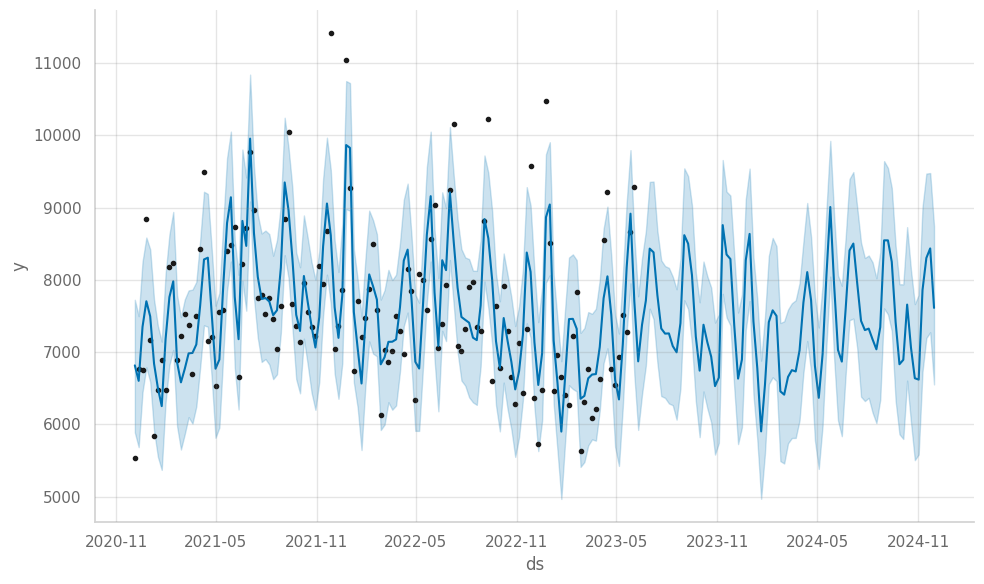

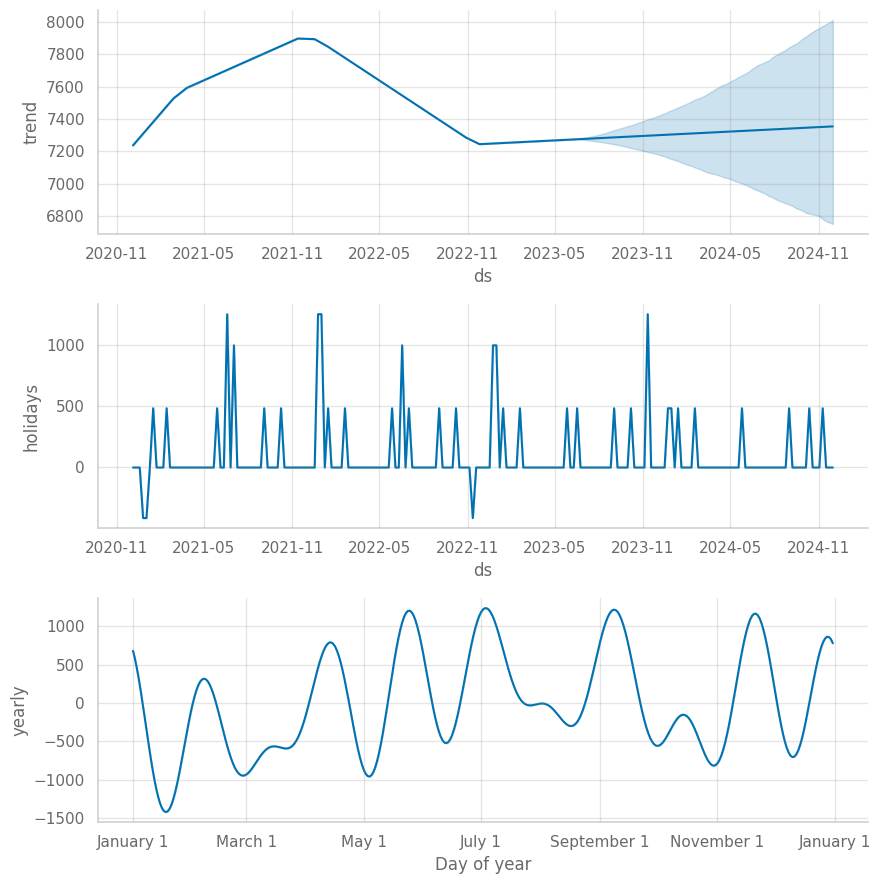

In [ ]:
fig12 = m2.plot(fcst_prophet_train2)
fig22 = m2.plot_components(fcst_prophet_train2)

forecasted_df2 = fcst_prophet_train2[fcst_prophet_train2['ds']>=forecast_start_date2]

In [ ]:
forecast_start_date2 = '2023-06-05'

future2 = m2.make_future_dataframe(periods=16, freq='W-SAT')
fcst_prophet_train2 = m2.predict(future2)

filter = fcst_prophet_train2['ds']>=forecast_start_date2
predicted_df2 = fcst_prophet_train2[filter][['ds','yhat']]



# Calculate Mean Absolute Percentage Error (MAPE)
mape_2 = mape(Q2_test_set_df['unit_sales'],predicted_df2['yhat'])


# Calculate Mean Absolute Error (MAE)
mae2 = mean_absolute_error(Q2_test_set_df['unit_sales'],predicted_df2['yhat'])

# Calculate Mean Squared Error (MSE)
mse2 = mean_squared_error(Q2_test_set_df['unit_sales'],predicted_df2['yhat'])

# Calculate Root Mean Squared Error (RMSE)
rmse2 = np.sqrt(mse2)

# Calculate R-squared (R2)
r2_2 = r2_score(Q2_test_set_df['unit_sales'],predicted_df2['yhat'])

print(f"-----------------------Features---------------------------")

print(f'Mean Absolute Error- MAE: {mae2}')
print(f'Mean Squared Error- MSE: {mse2}')
print(f'Root Mean Square Error- RMSE: {rmse2}')
print(f'R2:R-squared{r2_2}')
print(f'Mean Absolute Percentage Error- MAPE: {mape_2}')

-----------------------Features---------------------------
Mean Absolute Error- MAE: 680.8973524344741
Mean Squared Error- MSE: 866582.1593165355
Root Mean Square Error- RMSE: 930.9039474169907
R2:R-squared0.186693359273858
Mean Absolute Percentage Error- MAPE: 8.73032110140635


In [ ]:
forecast_start_date2_1 = "2024-03-16"

future2_1 = m2.make_future_dataframe(periods=60, freq='W-SAT')
fcst_prophet_train2_1 = m2.predict(future2_1)

filter = fcst_prophet_train2_1['ds']>=forecast_start_date2_1
predicted_df2_1 = fcst_prophet_train2_1[filter][['ds','yhat']]

In [ ]:
predicted_df2_1.head(20)

,ds,yhat
171,2024-03-16,6751.12
172,2024-03-23,6732.99
173,2024-03-30,7025.45
174,2024-04-06,7684.39
175,2024-04-13,8106.97
176,2024-04-20,7718.91
177,2024-04-27,6810.35
178,2024-05-04,6368.75
179,2024-05-11,6974.68
180,2024-05-18,8066.49


<Axes: xlabel='ds', ylabel='yhat'>

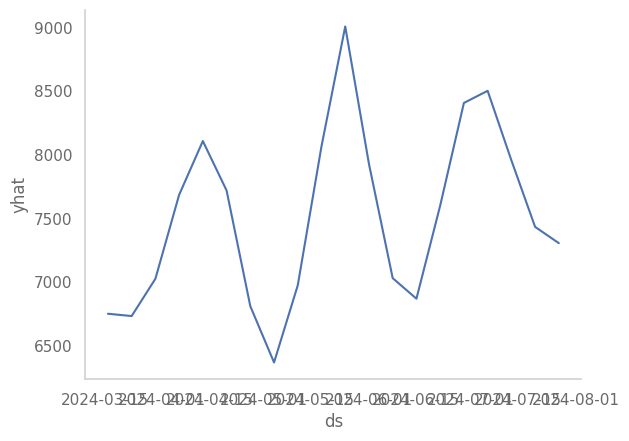

In [ ]:
# @title Predicted Value over Time

sns.lineplot(data=predicted_df2_1, x='ds', y='yhat')

From the above forecast we can see that if the drink is released 2 weeks before ester the sales will be around 6700 units and continues to grow and fall following the pattern above and can be expected to reach the high demand around 9000 in the 10th week or can be discontinued in the 8th week when the demand reaches the lowest at 6300 after first peak.

## <a name = "q3"> </a> 4.1.4. Question 3

Writing the segments for the Qestion 3.  
a. caloric Segment - Diet  
b. Market Category - Energy   
c. Manufacturer - Swire-CC  
d. Brand - Venomous Blast  
e. Package Type - 16 Liquid Small  
f. Flavor - Kiwano

In [ ]:
q3_f1 = fact_demand_state_data['caloric_segment'] == 'DIET/LIGHT'
q3_f2 = fact_demand_state_data['category'] == 'ENERGY'
q3_f3 = fact_demand_state_data['manufacturer'].str.lower().str.contains('swire')
q3_f4 = fact_demand_state_data['item'].str.lower().str.contains('kiwano')
q3_f5 = fact_demand_state_data['brand'].str.lower().str.contains('venomous blast')

filter_condition_q3 = ( q3_f1 & q3_f2 & q3_f3 & q3_f4 & q3_f5 )

q3_df = fact_demand_state_data[filter_condition_q3]

q3_df.head()

,date,market_key,caloric_segment,category,unit_sales,dollar_sales,manufacturer,brand,package,item,states
6992,2020-12-05,50,DIET/LIGHT,ENERGY,14.00,13.35,SWIRE-CC,VENOMOUS BLAST,16SMALL MULTI CUP,VENOMOUS BLAST ENERGY DRINK KIWANO DURIAN CU...,WA/ID
9306,2020-12-05,59,DIET/LIGHT,ENERGY,21.00,20.58,SWIRE-CC,VENOMOUS BLAST,16SMALL MULTI CUP,VENOMOUS BLAST ENERGY DRINK KIWANO DURIAN CU...,NV/CA
14406,2020-12-05,87,DIET/LIGHT,ENERGY,25.00,24.50,SWIRE-CC,VENOMOUS BLAST,16SMALL MULTI CUP,VENOMOUS BLAST ENERGY DRINK KIWANO DURIAN CU...,ID/NV
15169,2020-12-05,89,DIET/LIGHT,ENERGY,4.00,3.92,SWIRE-CC,VENOMOUS BLAST,16SMALL MULTI CUP,VENOMOUS BLAST ENERGY DRINK KIWANO DURIAN CU...,CA
16497,2020-12-05,111,DIET/LIGHT,ENERGY,14.00,13.72,SWIRE-CC,VENOMOUS BLAST,16SMALL MULTI CUP,VENOMOUS BLAST ENERGY DRINK KIWANO DURIAN CU...,CA


In [ ]:
q3_df.shape

(2171, 11)

In [ ]:
min(q3_df['date']), max(q3_df['date'])

(Timestamp('2020-12-05 00:00:00'), Timestamp('2023-10-28 00:00:00'))

In [ ]:
#q2_agg_df = q2_df.groupby(['date']).agg({'unit_sales':'sum'}).reset_index().sort_values(['date'])
q3_agg_df = q3_df.groupby(['date']).agg({'unit_sales': 'sum', 'item': 'nunique'}).reset_index().sort_values(['date'])
q3_agg_df['unit_sales'] = q3_agg_df['unit_sales'] / q3_agg_df['item']
q3_agg_df.drop(columns=['item'],inplace=True)

In [ ]:
q3_agg_df.head()

,date,unit_sales
0,2020-12-05,595.00
1,2020-12-12,694.00
2,2020-12-19,601.00
3,2020-12-26,567.00
4,2021-01-02,564.00


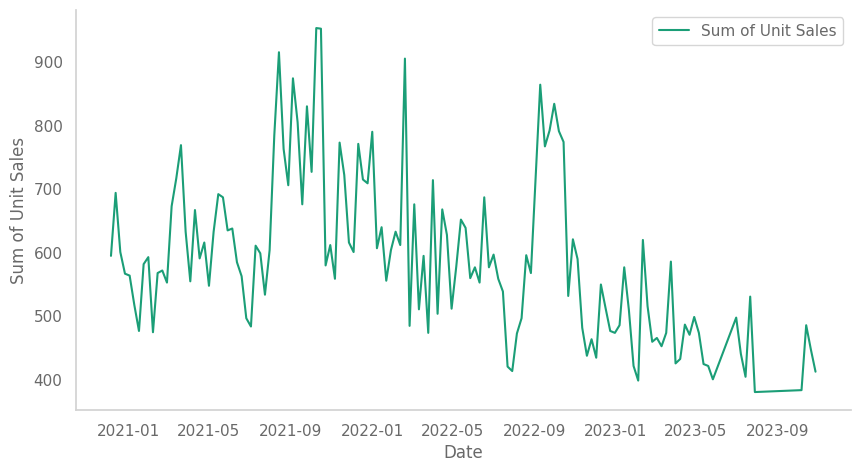

In [ ]:
# @title date vs sum of unit_sales for Q3

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
    # Aggregate sum of unit sales by date
  summed = series.groupby('date')['unit_sales'].sum().reset_index()

  xs = summed['date']
  ys = summed['unit_sales']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

# Example usage:
fig, ax = plt.subplots(figsize=(10, 5.2))
df_sorted = q3_agg_df.sort_values('date', ascending=True)
_plot_series(df_sorted, 'Sum of Unit Sales')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
plt.ylabel('Sum of Unit Sales')
plt.legend()
plt.show()

In [ ]:
Q3_sales_data_df = q3_agg_df[q2_agg_df.date<='2023-06-05']
Q3_test_set_df = q3_agg_df[q2_agg_df.date>='2023-06-05']

In [ ]:
Q3_sales_data_df.head()

,date,unit_sales
0,2020-12-05,595.00
1,2020-12-12,694.00
2,2020-12-19,601.00
3,2020-12-26,567.00
4,2021-01-02,564.00


In [ ]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
seasonality_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()

In [ ]:
# getting the best parametes for Question 2
params3_dict = best_params(Q3_sales_data_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/_0lxbv5k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/qrbd68vh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61522', 'data', 'file=/tmp/tmpds087y2r/_0lxbv5k.json', 'init=/tmp/tmpds087y2r/qrbd68vh.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model4o6_3b27/prophet_model-20240331183316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:33:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:33:16 - cmdstanpy - ERROR - Chain [1]

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/asmoggii.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/if9tkdnx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41210', 'data', 'file=/tmp/tmpds087y2r/asmoggii.json', 'init=/tmp/tmpds087y2r/if9tkdnx.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelhxna35ay/prophet_model-20240331183316.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:33:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/0j1j8d08.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/_q2prp6s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/_c8fkamv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/o18m0rws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12376', 'data', 'file=/tmp/tmpds087y2r/_c8fkamv.json', 'init=/tmp/tmpds087y2r/o18m0rws.json', 'output', 'file=/tmp/tmpds087y2r/prophet_models9qj8pqi/prophet_model-20240331183324.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:33:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/k0mpz1cn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/74bhdqlv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/leulwe43.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/q0ap7n85.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35223', 'data', 'file=/tmp/tmpds087y2r/leulwe43.json', 'init=/tmp/tmpds087y2r/q0ap7n85.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model45xq3v39/prophet_model-20240331183338.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:33:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/c3pktouw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/yat_5viu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/roimtz1f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/todn4jr4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46798', 'data', 'file=/tmp/tmpds087y2r/roimtz1f.json', 'init=/tmp/tmpds087y2r/todn4jr4.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelhcad93r1/prophet_model-20240331183347.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:33:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/amgy9bv2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/69tmlxy7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/9iecz2s_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/sdw2t4dl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46082', 'data', 'file=/tmp/tmpds087y2r/9iecz2s_.json', 'init=/tmp/tmpds087y2r/sdw2t4dl.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modellhohpw56/prophet_model-20240331183358.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:33:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:33:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/w2x4cued.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/o8q_1y_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/jq_834yv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/l02xeo5q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47979', 'data', 'file=/tmp/tmpds087y2r/jq_834yv.json', 'init=/tmp/tmpds087y2r/l02xeo5q.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelpowmg00z/prophet_model-20240331183412.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:34:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/jtyduw42.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/btjsb8hl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/iyei3ni9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/ybodp8ee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72827', 'data', 'file=/tmp/tmpds087y2r/iyei3ni9.json', 'init=/tmp/tmpds087y2r/ybodp8ee.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelhj8hnvvq/prophet_model-20240331183418.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:34:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/kqw7zo49.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/a6n_9507.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/l4gd2vd1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/0ou30yx5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79364', 'data', 'file=/tmp/tmpds087y2r/l4gd2vd1.json', 'init=/tmp/tmpds087y2r/0ou30yx5.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modeljsghy2hj/prophet_model-20240331183423.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:34:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/la37c27i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/2kla89kc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/p16pwa12.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/j0soi1ja.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81265', 'data', 'file=/tmp/tmpds087y2r/p16pwa12.json', 'init=/tmp/tmpds087y2r/j0soi1ja.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelkptkdi7r/prophet_model-20240331183429.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:34:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/akd6wbpo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/enfog7cq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/il1_mfqb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/uvgg497t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37275', 'data', 'file=/tmp/tmpds087y2r/il1_mfqb.json', 'init=/tmp/tmpds087y2r/uvgg497t.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelj4qm7d3a/prophet_model-20240331183436.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:34:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/ikfgfvhy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/ibhj20mq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/z7vbakbn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/wn35vkc0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5921', 'data', 'file=/tmp/tmpds087y2r/z7vbakbn.json', 'init=/tmp/tmpds087y2r/wn35vkc0.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelweha86qj/prophet_model-20240331183441.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:34:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/edx68d7k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/iayjmkz_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/e0qe6e1l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/y7jwldqr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74237', 'data', 'file=/tmp/tmpds087y2r/e0qe6e1l.json', 'init=/tmp/tmpds087y2r/y7jwldqr.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model_8ry1ya6/prophet_model-20240331183448.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:34:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/8z64kegt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/idtb_lt0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/cli_barr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/o9vy9j43.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52116', 'data', 'file=/tmp/tmpds087y2r/cli_barr.json', 'init=/tmp/tmpds087y2r/o9vy9j43.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelsa0yu_zt/prophet_model-20240331183455.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:34:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:34:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/sibsf0qq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/kpunz2r7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/3ab7fb4f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/p6i694_m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32219', 'data', 'file=/tmp/tmpds087y2r/3ab7fb4f.json', 'init=/tmp/tmpds087y2r/p6i694_m.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelo_qg5wj9/prophet_model-20240331183500.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:35:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/c51e2vbn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/p8dph1sf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/kz5h6iu2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/a5m7fcgy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21756', 'data', 'file=/tmp/tmpds087y2r/kz5h6iu2.json', 'init=/tmp/tmpds087y2r/a5m7fcgy.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model_ei0voo9/prophet_model-20240331183507.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:35:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/f5ihe106.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/e08ihlsn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/w3hl3e9g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/9o8948p8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40459', 'data', 'file=/tmp/tmpds087y2r/w3hl3e9g.json', 'init=/tmp/tmpds087y2r/9o8948p8.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelk0gmvitk/prophet_model-20240331183513.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:35:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/wntu8jj8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/12r28te6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/pumczm73.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/eidm3nj5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58292', 'data', 'file=/tmp/tmpds087y2r/pumczm73.json', 'init=/tmp/tmpds087y2r/eidm3nj5.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelljdmsmv7/prophet_model-20240331183521.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:35:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/0y9_8jnt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/d41r49uy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/e2wjyzdv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/kxrokkau.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94356', 'data', 'file=/tmp/tmpds087y2r/e2wjyzdv.json', 'init=/tmp/tmpds087y2r/kxrokkau.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model0onluvkp/prophet_model-20240331183527.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:35:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/up8t65lh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/9q9qunca.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/bw8ucy6u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/eapc131g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7103', 'data', 'file=/tmp/tmpds087y2r/bw8ucy6u.json', 'init=/tmp/tmpds087y2r/eapc131g.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model2th0chpv/prophet_model-20240331183534.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:35:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/oeieovrz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/pv30_r_u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/zdnfsdvt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/b6zh37qz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48126', 'data', 'file=/tmp/tmpds087y2r/zdnfsdvt.json', 'init=/tmp/tmpds087y2r/b6zh37qz.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modeldc1uufnj/prophet_model-20240331183541.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:35:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/9em_jl9b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/mzy7tss2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/xkb90l7x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/ne7en78f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61807', 'data', 'file=/tmp/tmpds087y2r/xkb90l7x.json', 'init=/tmp/tmpds087y2r/ne7en78f.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modeljno6b10q/prophet_model-20240331183547.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:35:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/czsa1_mx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/kvecdc5_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/amuz3t3j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/790gxn55.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76049', 'data', 'file=/tmp/tmpds087y2r/amuz3t3j.json', 'init=/tmp/tmpds087y2r/790gxn55.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modelvx6bw4gg/prophet_model-20240331183556.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:35:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:35:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/gju7ib07.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/q3zq4xuy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/3idsno9p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/3052v39n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58794', 'data', 'file=/tmp/tmpds087y2r/3idsno9p.json', 'init=/tmp/tmpds087y2r/3052v39n.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model9lmnmmvm/prophet_model-20240331183603.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:36:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/nlb672f2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/_owdnp9f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/qsxd3z0p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/jei9j119.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11936', 'data', 'file=/tmp/tmpds087y2r/qsxd3z0p.json', 'init=/tmp/tmpds087y2r/jei9j119.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model6_dwto0v/prophet_model-20240331183610.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:36:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/n5yvf4es.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/a1wwjsgf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/1t1yjipi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/q2uij6b4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37926', 'data', 'file=/tmp/tmpds087y2r/1t1yjipi.json', 'init=/tmp/tmpds087y2r/q2uij6b4.json', 'output', 'file=/tmp/tmpds087y2r/prophet_model77b_h8tk/prophet_model-20240331183618.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
18:36:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/vgcgqrbp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/4r_8261w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

In [ ]:
params3_dict

{'changepoint_prior_scale': 0.2505,
 'seasonality_prior_scale': 0.001,
 'mape': 0.15700736216716907}

In [ ]:
prediction_days = 16
forecast_start_date3 = max(Q3_sales_data_df.ds) - timedelta(prediction_days)

category_df3 = Q3_sales_data_df[['ds','y']]


#PROPHET MODEL

#model
m3 = Prophet(changepoint_prior_scale=params3_dict['changepoint_prior_scale'],
            seasonality_prior_scale=params3_dict['seasonality_prior_scale'],
            holidays=holiday)

m3.fit(category_df3)

future3 = m3.make_future_dataframe(periods=78, freq='W-SAT')
fcst_prophet_train3 = m3.predict(future3)

filter = fcst_prophet_train3['ds']>=forecast_start_date3
predicted_df3 = fcst_prophet_train3[filter][['ds','yhat']]
predicted_df3 = predicted_df3.merge(category_df3)

print(mape(predicted_df3['y'],predicted_df3['yhat']))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/ldyp85iu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpds087y2r/fp418vf4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58321', 'data', 'file=/tmp/tmpds087y2r/ldyp85iu.json', 'init=/tmp/tmpds087y2r/fp418vf4.json', 'output', 'file=/tmp/tmpds087y2r/prophet_modellpb41k79/prophet_model-20240331183625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:36:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:36:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


14.260138033759562


In [ ]:
print(forecast_start_date3)

2023-06-15 00:00:00


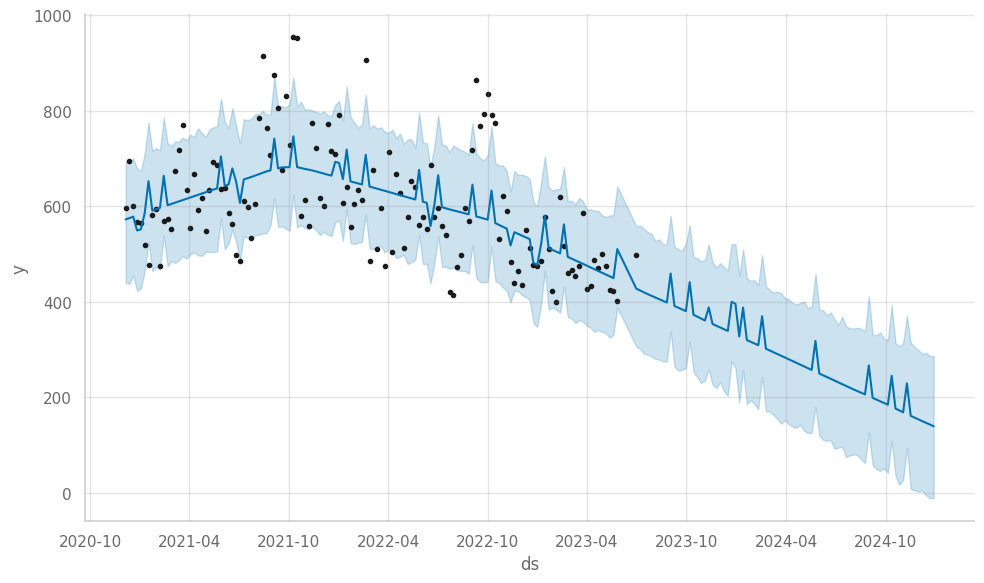

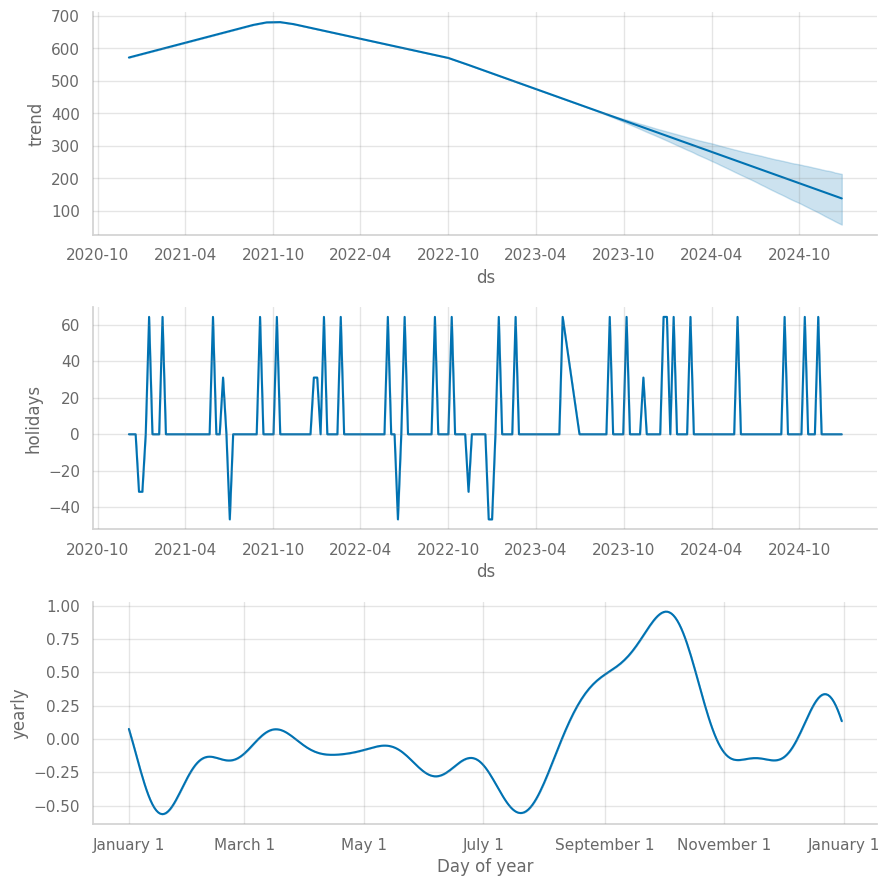

In [ ]:
fig12 = m3.plot(fcst_prophet_train3)
fig22 = m3.plot_components(fcst_prophet_train3)

forecasted_df3 = fcst_prophet_train3[fcst_prophet_train3['ds']>=forecast_start_date3]

In [ ]:
Q3_test_set_df.head()

,date,unit_sales
131,2023-07-08,441.00
132,2023-07-15,405.00
133,2023-07-22,531.00
134,2023-07-29,381.00
135,2023-10-07,384.00


In [ ]:
Q3_test_set_df.shape

(8, 2)

In [ ]:
forecast_start_date3 = '2023-07-08'

future3 = m3.make_future_dataframe(periods=8, freq='W-SAT')
fcst_prophet_train3 = m3.predict(future3)

filter = fcst_prophet_train3['ds']>=forecast_start_date3
predicted_df3 = fcst_prophet_train3[filter][['ds','yhat']]



# Calculate Mean Absolute Percentage Error (MAPE)
mape_3 = mape(Q3_test_set_df['unit_sales'],predicted_df3['yhat'])


# Calculate Mean Absolute Error (MAE)
mae3 = mean_absolute_error(Q3_test_set_df['unit_sales'],predicted_df3['yhat'])

# Calculate Mean Squared Error (MSE)
mse3 = mean_squared_error(Q3_test_set_df['unit_sales'],predicted_df3['yhat'])

# Calculate Root Mean Squared Error (RMSE)
rmse3 = np.sqrt(mse3)

# Calculate R-squared (R2)
r2_3 = r2_score(Q3_test_set_df['unit_sales'],predicted_df3['yhat'])

print(f"-----------------------Features---------------------------")

print(f'Mean Absolute Error- MAE: {mae3}')
print(f'Mean Squared Error- MSE: {mse3}')
print(f'Root Mean Square Error- RMSE: {rmse3}')
print(f'R2:R-squared{r2_3}')
print(f'Mean Absolute Percentage Error- MAPE: {mape_3}')

-----------------------Features---------------------------
Mean Absolute Error- MAE: 43.1848995760875
Mean Squared Error- MSE: 3044.3237944335333
Root Mean Square Error- RMSE: 55.17539120326682
R2:R-squared-0.28772544393532273
Mean Absolute Percentage Error- MAPE: 9.31052312243734


# <a name = "Conclusion"> </a> 7. Conclusion

Overall, we found that the Prophet model is good as it provided the less MAPE value, which is the Percentage error for the Mean Absolute values. So when error is less that means that the model is good in predicting the sales correctly.

Since, the data is filtered to be similar to the new innovation drinks in each of the question, the forecast will be similar to the original sales, which we can see from the less MAPE values.

# <a name = "group"> </a> 8. Group Member Contribution


**Sai Anogna Chittudi:** I have started with checking the data in the BigQuery seperately for data related to each question, so that the attributes matches to the New Innovation products in each question as closly as possible, so that the forecast will be good. Then, I have created the Prophet model for the Questions 1,2 and 3 along with Visulizations and hyperparameter tuning for each of the datasets seperately. Completed the Introduction and the data Preparation sections.